<a href="https://colab.research.google.com/github/fbeilstein/topological_data_analysis/blob/master/lecture_5_tsne_umap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* [t-SNE demo (external)](https://distill.pub/2016/misread-tsne/)
* [UMAP demo (external)](https://pair-code.github.io/understanding-umap/)

###GPU-based code (switch runtime to T4)

In [ ]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

try:
  from cuml.manifold import TSNE
  from cuml.manifold import UMAP
  from google.colab import output
  output.clear()
except:
  print('ERROR')
finally:
  print('COMPLETE')

COMPLETE


In [ ]:
#from cuml.manifold import TSNE
#from cuml.manifold import UMAP
#
#reducer = TSNE(n_components=n_components, n_neighbors=n_neighbors, perplexity=perplexity, method='fft')
#reducer = UMAP(n_components=n_components, n_neighbors=n_neighbors)

###CPU-based code

In [ ]:
!pip install umap-learn

try:
  from umap import UMAP
  from google.colab import output
  output.clear()
except:
  print('ERROR')
finally:
  print('COMPLETE')

COMPLETE


In [ ]:
#from sklearn.manifold import TSNE
#from umap import UMAP
#
#reducer_tsne = TSNE(n_components=n_components, perplexity=perplexity, method='barnes_hut')
#reducer_umap = UMAP(n_components=n_components, n_neighbors=n_neighbors)

/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return init_func(self, *args, **filtered_kwargs)


[I] [14:57:14.863288] Building knn graph using brute force


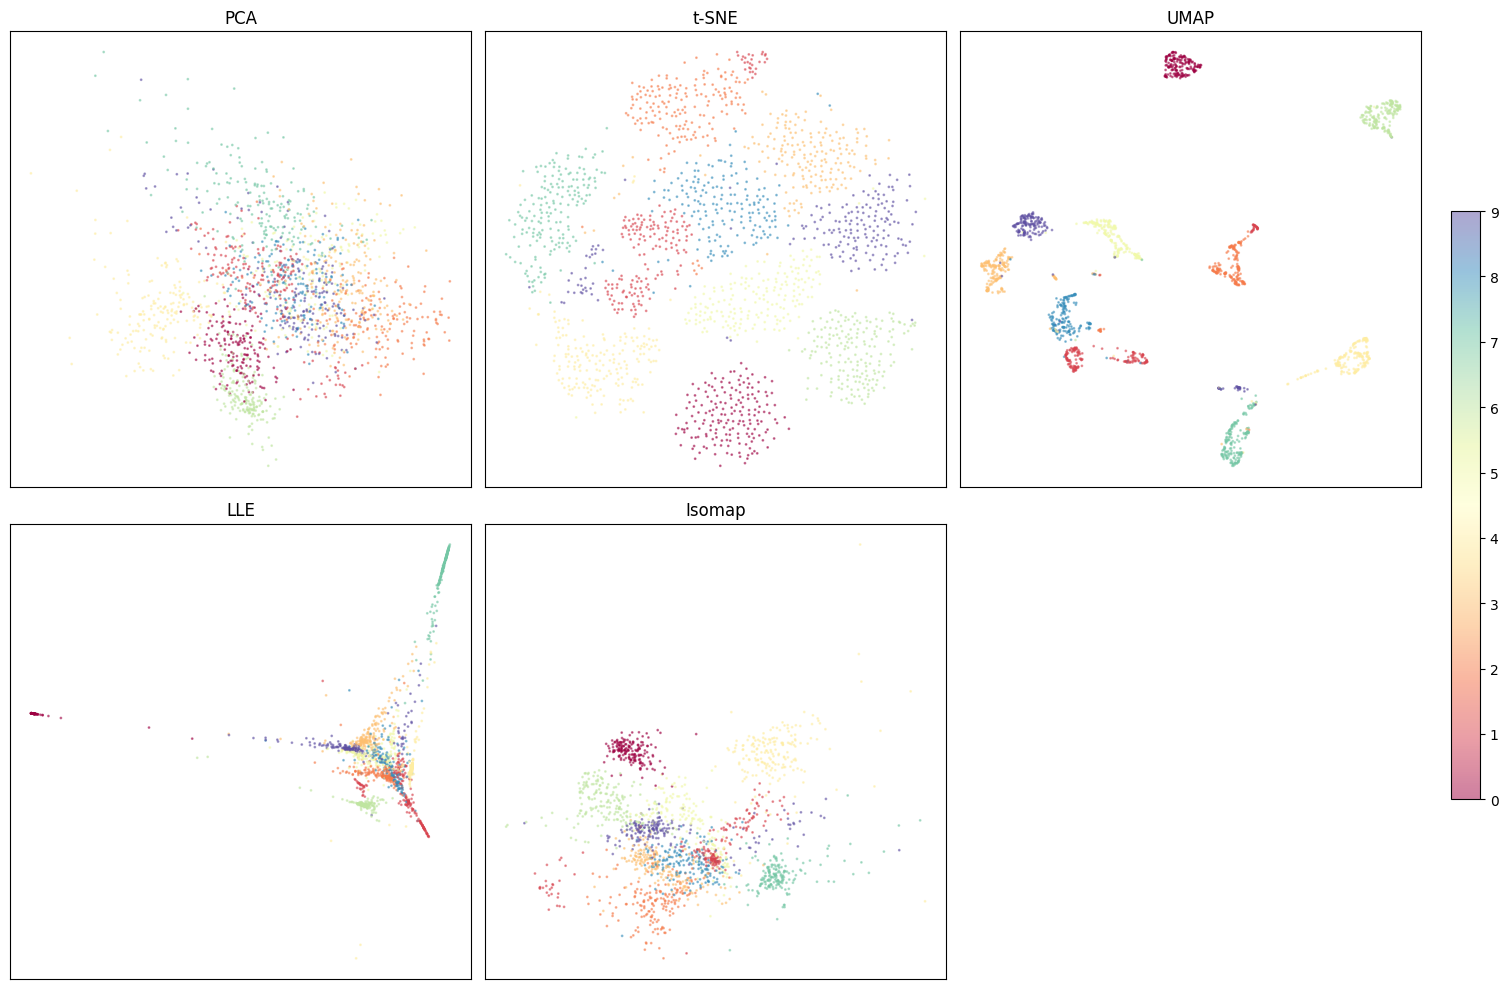

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import LocallyLinearEmbedding, Isomap
from sklearn.decomposition import PCA
#import umap
from cuml.manifold import TSNE
from cuml.manifold import UMAP
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits

# Load smaller digits dataset
digits = load_digits()
X, y = digits.data, digits.target  # (1797 samples, 64 features)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Apply different dimensionality reduction techniques
reducers = {
  "PCA": PCA(n_components=2),
  "t-SNE": TSNE(n_components=2, perplexity=30),
  "UMAP": UMAP(n_components=2),
  "LLE": LocallyLinearEmbedding(n_components=2, n_neighbors=10),
  "Isomap": Isomap(n_components=2, n_neighbors=10)
}

# Transform data using each method
results = {name: reducer.fit_transform(X_scaled) for name, reducer in reducers.items()}

# Plot results
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, (name, embedding) in enumerate(results.items()):
  scatter = axes[i].scatter(embedding[:, 0], embedding[:, 1], c=y, cmap='Spectral', alpha=0.5, s=1)
  axes[i].set_title(name)
  axes[i].set_xticks([])
  axes[i].set_yticks([])

# Remove the last empty subplot
fig.delaxes(axes[-1])

plt.tight_layout()
plt.colorbar(scatter, ax=axes, fraction=0.02, pad=0.02)
plt.show()


##t-SNE

### **t-Distributed Stochastic Neighbor Embedding (t-SNE)**
t-SNE is a nonlinear dimensionality reduction technique used for visualizing high-dimensional datasets. It minimizes the divergence between two distributions: **a probability distribution over pairs of high-dimensional points** and **a probability distribution over pairs of low-dimensional points**.

### **Step 1: Compute Pairwise Similarities in High-Dimensional Space**
For a given dataset **X** with `n` points, t-SNE defines a probability distribution $p_{ij}$ that measures the similarity between points $x_i$ and $x_j$.

The conditional probability that $x_j$ is a neighbor of $x_i$ is defined using a Gaussian kernel:

$$
p_{j|i} = \frac{\exp(-\|x_i - x_j\|^2 / 2\sigma_i^2)}{\sum_{k \neq i} \exp(-\|x_i - x_k\|^2 / 2\sigma_i^2)}
$$

where $σ_i$ is the **perplexity-controlled variance** of the Gaussian centered at $x_i$.

The symmetric joint probability distribution is then:

$$
p_{ij} = \frac{p_{j|i} + p_{i|j}}{2n}
$$

#### **Step 2: Compute Pairwise Similarities in Low-Dimensional Space**
We now define a similar probability distribution $q_ij$ in the lower-dimensional space. Instead of a Gaussian kernel, t-SNE uses a **Student's t-distribution** with one degree of freedom (equivalent to a Cauchy distribution):

$$
q_{ij} = \frac{(1 + \|y_i - y_j\|^2)^{-1}}{\sum_{k \neq l} (1 + \|y_k - y_l\|^2)^{-1}}
$$

where **y_i** and **y_j** are the low-dimensional embeddings.

#### **Step 3: Minimize the Kullback-Leibler (KL) Divergence**
The cost function minimized by t-SNE is the **Kullback-Leibler divergence (KL-divergence)** between the distributions **P** and **Q**:

$$
C = \sum_{i \neq j} p_{ij} \log \frac{p_{ij}}{q_{ij}}
$$

A gradient descent method is used to minimize this function.

#### **Step 4: Gradient Descent Update Rule**
The gradient of **C** with respect to $y_i$ is:

$$
\frac{\delta C}{\delta y_i} = 4 \sum_{j} (p_{ij} - q_{ij})(y_i - y_j)(1 + \|y_i - y_j\|^2)^{-1}
$$

t-SNE applies **momentum** and an adaptive learning rate:

$$
y_i^{(t)} = y_i^{(t-1)} + \eta \frac{\delta C}{\delta y_i} + \alpha^{(t)} (y_i^{(t-1)} - y_i^{(t-2)})
$$

where:
- **η** is the learning rate,
- **α(t)** is the momentum term.

#### **Step 5: Iterative Optimization**
1. Initialize $y_i$ randomly.
2. Compute $p_{ij}$ using a Gaussian kernel in high-dimensional space.
3. Compute $q_{ij}$ using a Student's t-distribution in low-dimensional space.
4. Minimize the KL-divergence using gradient descent.
5. Apply momentum and adjust learning rates for stability.

##### **Key Parameters of t-SNE**
- **Perplexity (Perp):** Controls the size of local neighborhoods.
- **Learning Rate (η):** Affects convergence speed and stability.
- **Number of Iterations (T):** Controls the number of optimization steps.

##### **Advantages of t-SNE**
- Captures **local** structure well.
- Effective for **visualization** of complex datasets.

##### **Limitations**
- Computationally expensive (**O(n²)** complexity).
- Hard to interpret global relationships.

---

### **Perplexity in t-SNE**
Perplexity is a key parameter in t-SNE that determines the **effective number of nearest neighbors** when computing the pairwise similarities in high-dimensional space. It is defined as:

$$
\text{Perplexity}(P_i) = 2^{H(P_i)}
$$

where $ H(P_i) $ is the **Shannon entropy** of the probability distribution over neighbors:

$$
H(P_i) = - \sum_{j \neq i} p_{j|i} \log_2 p_{j|i}
$$

The perplexity value is user-defined and typically ranges from **5 to 50**. It controls the variance $ \sigma_i^2 $ of the Gaussian kernel:

$$
p_{j|i} = \frac{\exp(-\|x_i - x_j\|^2 / 2\sigma_i^2)}{\sum_{k \neq i} \exp(-\|x_i - x_k\|^2 / 2\sigma_i^2)}
$$

#### **Finding the Optimal $ \sigma_i $**
t-SNE does not take $ \sigma_i $ as a direct input. Instead, it searches for $ \sigma_i $ such that the entropy matches the user-defined perplexity:

$$
H(P_i) = \log_2 (\text{Perplexity})
$$

This is done via **binary search** over $\sigma_i$ to find a value that satisfies the equation.

#### **Intuition Behind Perplexity**
- **Small perplexity (e.g., 5-10):** t-SNE focuses on very local structures, grouping only the closest points together.
- **Large perplexity (e.g., 30-50):** It captures a broader view, including more distant points.
- **Very large perplexity ($\gg 50$):** Approaches linear methods like PCA, losing the fine structure.

##### **Practical Considerations**
- Increasing perplexity makes results more **global** (preserving larger structures).
- Decreasing perplexity makes t-SNE emphasize **local** clusters.
- If the dataset is very large, choosing **too small** a perplexity may lead to fragmentation.

---


##UMAP

To demonstrate the process let’s consider a test dataset like this

![img](https://umap-learn.readthedocs.io/en/latest/_images/how_umap_works_raw_data.png)

If we consider data that is uniformly distributed along the same manifold it is not hard to pick a good radius (a little above half the average distance between points) and the resulting open cover looks pretty good:
![img](https://umap-learn.readthedocs.io/en/latest/_images/how_umap_works_uniform_distribution_cover.png)

![img](https://umap-learn.readthedocs.io/en/latest/_images/how_umap_works_open_cover.png)


Each point is given its own unique distance function, and we can simply select balls of radius one with respect to that local distance function
![img](https://umap-learn.readthedocs.io/en/latest/_images/how_umap_works_local_metric_open_cover.png)


Of course we have traded choosing the radius of the balls for choosing a value for k. However it is often easier to pick a resolution scale in terms of number of neighbors than it is to correctly choose a distance. This is because choosing a distance is very dataset dependent: one needs to look at the distribution of distances in the dataset to even begin to select a good value. In contrast, while a k value is still dataset dependent to some degree, there are reasonable default choices, such as the 10 nearest neighbors, that should work acceptably for most datasets.


In slightly more mathematical terms we can think of this as working in a fuzzy topology where being in an open set in a cover is no longer a binary yes or no, but instead a fuzzy value between zero and one. Obviously the certainty that points are in a ball of a given radius will decay as we move away from the center of the ball. We could visualize such a fuzzy cover as looking something like this
![img](https://umap-learn.readthedocs.io/en/latest/_images/how_umap_works_fuzzy_open_cover.png)

This resolves a number of issues, but a new problem presents itself when we apply this sort of process to real data, especially in higher dimensions: a lot of points become essentially totally isolated.


For the practical problem we are working with, where we only have a finite approximation of the manifold, this means that no point should be completely isolated – it should connect to at least one other point. In terms of fuzzy open sets what this amounts to is that we should have complete confidence that the open set extends as far as the closest neighbor of each point. We can implement this by simply having the fuzzy confidence decay in terms of distance beyond the first nearest neighbor. We can visualize the result in terms of our example dataset again.


![img](https://umap-learn.readthedocs.io/en/latest/_images/how_umap_works_umap_open_cover.png)


Just when we think we are almost there, having worked around some of the issues of real world data, we run aground on a new obstruction: our local metrics are not compatible! Each point has its own local metric associated to it, and from point a's perspective the distance from point a to point b might be 1.5, but from the perspective of point b the distance from point b to point a might only be 0.6. Which point is right? How do we decide? Going back to our graph based intuition we can think of this as having directed edges with varying weights something like this.

![img](https://umap-learn.readthedocs.io/en/latest/_images/how_umap_works_raw_graph.png)

if we want to merge together two disagreeing edges with weight $a$ and $b$ then we should have a single edge with combined weight
$a + b - a \cdot b$. The way to think of this is that the weights are effectively the probabilities that an edge (1-simplex) exists. The combined weight is then the probability that at least one of the edges exists.


If we apply this process to union together all the fuzzy simplicial sets we end up with a single fuzzy simplicial complex, which we can again think of as a weighted graph. In computational terms we are simply applying the edge weight combination formula across the whole graph (with non-edges having a weight of 0). In the end we have something that looks like this.


![img](https://umap-learn.readthedocs.io/en/latest/_images/how_umap_works_umap_graph.png)


So in some sense in the end we have simply constructed a weighted graph (although we could make use of higher dimensional simplices if we wished, just at significant extra computational cost).


Going back to when we were merging together the conflicting weights associated to simplices, we interpreted the weights as the probability of the simplex existing. Thus, since both topological structures we are comparing share the same 0-simplices, we can imagine that we are comparing the two vectors of probabilities indexed by the 1-simplices. Given that these are Bernoulli variables (ultimately the simplex either exists or it doesn't, and the probability is the parameter of a Bernoulli distribution), the right choice here is the cross entropy.



Explicitly, if the set of all possible 1-simplices is $E$, and we
have weight functions such that $w_h(e)$ is the weight of the
1-simplex $e$ in the high dimensional case and $w_l(e)$ is
the weight of $e$ in the low dimensional case, then the cross
entropy will be
$$
\sum_{e\in E} w_h(e) \log\left(\frac{w_h(e)}{w_l(e)}\right) + (1 - w_h(e)) \log\left(\frac{1 - w_h(e)}{1 - w_l(e)}\right)
$$

This might look complicated, but if we go back to thinking in terms of a
graph we can view minimizing the cross entropy as a kind of force
directed graph layout algorithm.

The first term, $w_h(e) \log\left(\frac{w_h(e)}{w_l(e)}\right)$,
provides an attractive force between the points $e$ spans whenever
there is a large weight associated to the high dimensional case. This is
because this term will be minimized when $w_l(e)$ is as large as
possible, which will occur when the distance between the points is as
small as possible.


In contrast the second term, $(1 - w_h(e)) \log\left(\frac{1 - w_h(e)}{1 - w_l(e)}\right)$, provides a repulsive force between the ends of $e$ whenever $w_h(e)$ is small. This is because the term will be minimized by
making $w_l(e)$ as small as possible.


On balance this process of pull and push, mediated by the weights on
edges of the topological representation of the high dimensional data,
will let the low dimensional representation settle into a state that
relatively accurately represents the overall topology of the source
data.